## Statistics 504 Homework #2 <br>
DRAFT 1.0 <br>
Fall 2015 <br>
Erich Seamon <br>
University of Idaho <br>
erichs@uidaho.edu <br>
http://github.com/erichseamon.com/stat504-python <br>

This assignment uses a small subset of the data from Kaggle's Yelp Business Rating Prediction competition. The data set is at https://github.com/justmarkham/DAT7/tree/master/data/yelp.csv
Description of the data: Each observation in this dataset is a review of a particular business by a particular user. The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) The "cool" column is the number of "cool" votes this particular review received from other Yelp users. There is no limit to how many "cool" votes a review can receive. The "useful" and "funny" columns are similar to the "cool" column.


#### TASK 1: read yelp.csv into a DataFrame

In [2]:
import matplotlib
%matplotlib nbagg

import pandas as pd
import numpy as np
import random
#random.seed(1234567) #setting the random seed for reproducible results consistent across our class - fall 2015
yelp = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT7/master/data/yelp.csv')

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


#### TASK 2: create a new DataFrame that only contains the 5-star and 1-star reviews

In [3]:
yelp_best_worst = yelp[(yelp.stars==5) | (yelp.stars==1)]

#### TASK 3: Use a random seed 1234567, split the new DataFrame into training and testing sets

In [4]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(yelp_best_worst.text, yelp_best_worst.stars, random_state=1234567)

#### TASK 4: use CountVectorizer to create document-term matrices from X_train and X_test

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.transform(X_test)

In [6]:
train_dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
vect2 = CountVectorizer()
X = vect2.fit_transform(yelp_best_worst.text)
y = yelp_best_worst.stars

#### TASK 5a: use Logistic Regression to predict the star rating for the testing set, and calculate accuracy

In [8]:
from sklearn import linear_model, datasets
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(train_dtm, y_train)
y_pred_class = logreg.predict(test_dtm)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.936399217221


#### TASK 5b: use K-Nearest Neighbors to predict the star rating for the testing set, and calculate accuracy

In [9]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_dtm, y_train)
y_pred_class = neigh.predict(test_dtm)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.824853228963


###### Calculate TRAINING ERROR and TESTING ERROR for K=1 through 50 for K-Nearest Neighbors

In [10]:
# calculate TRAINING ERROR and TESTING ERROR for K=1 through 50
k_range = range(1, 50)
training_error = []
testing_error = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # training error
    knn.fit(X, y)
    y_pred = knn.predict(X)
    training_error.append(1 - metrics.accuracy_score(y, y_pred))
    # testing error
    knn.fit(train_dtm, y_train)
    y_pred = knn.predict(test_dtm)
    testing_error.append(1 - metrics.accuracy_score(y_test, y_pred))

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#### Plot the relationship between K (HIGH TO LOW) and TESTING ERROR

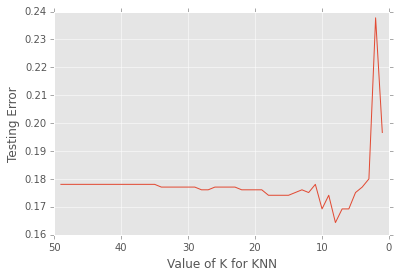

In [12]:
# plot the relationship between K (HIGH TO LOW) and TESTING ERROR
plt.plot(k_range, testing_error)
plt.gca().invert_xaxis()
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Error')

In [13]:
df = pd.DataFrame({'K': k_range, 'train':training_error, 'test':testing_error}).set_index('K').sort_index(ascending=False)

#### Plot both test and train datasets for k and test error

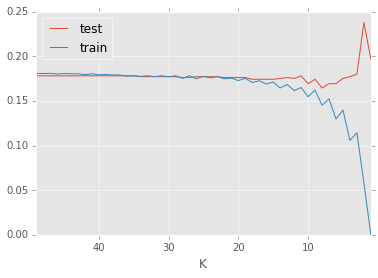

In [14]:
df.plot()

#### TASK 5c: use Classification Tree to predict the star rating for the testing set, and calculate accuracy

In [15]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(train_dtm, y_train)
y_pred_class = clf.predict(test_dtm)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.853228962818


In [16]:
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 

In [17]:
graph.write_jpeg("yelp_tree_plot.jpg")

True

In [18]:
from IPython.display import Image
Image(filename='yelp_tree_plot.jpg')

### Calculate AUC and ROC for all three models

#### TASK 6a: calculate the logistic regression AUC

In [22]:
# TASK 6: calculate the logistic regression AUC
log_y_pred_prob = logreg.predict_proba(test_dtm)[:, 1]
import numpy as np
log_y_test_binary = np.where(y_test==5, 1, 0)
print metrics.roc_auc_score(log_y_test_binary, log_y_pred_prob)

0.962367377245


#### TASK 6b: calculate the k nearest neighbors AUC

In [23]:
# TASK 6: calculate the k nearest neighbors AUC
knn_y_pred_prob = neigh.predict_proba(test_dtm)[:, 1]
import numpy as np
knn_y_test_binary = np.where(y_test==5, 1, 0)
print metrics.roc_auc_score(knn_y_test_binary, knn_y_pred_prob)

0.69734005484


#### TASK 6c: calculate the classification tree AUC

In [24]:
# TASK 6: calculate the k nearest neighbors AUC
tree_y_pred_prob = clf.predict_proba(test_dtm)[:, 1]
import numpy as np
tree_y_test_binary = np.where(y_test==5, 1, 0)
print metrics.roc_auc_score(tree_y_test_binary, tree_y_pred_prob)

0.743977021825


#### TASK 7: plot the ROC curves for all three models

<IPython.core.display.Javascript object>


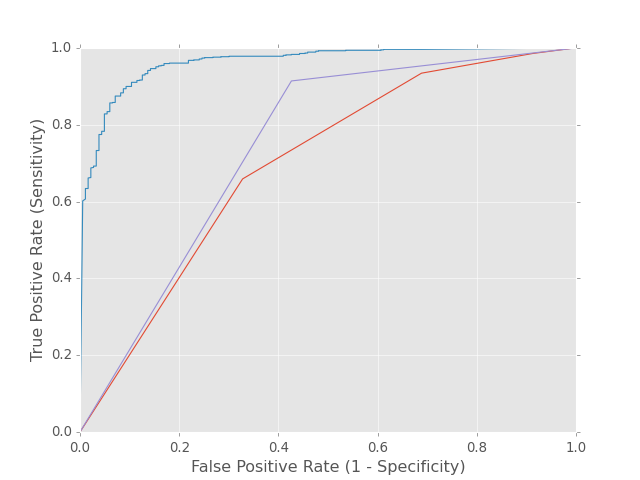

In [27]:
# TASK 7: plot the ROC curve
import matplotlib
%matplotlib nbagg

import matplotlib.pyplot as plt
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(knn_y_test_binary, knn_y_pred_prob)
plt.plot(knn_fpr, knn_tpr)

log_fpr, log_tpr, thresholds = metrics.roc_curve(log_y_test_binary, log_y_pred_prob)
plt.plot(log_fpr, log_tpr)

tree_fpr, tree_tpr, thresholds = metrics.roc_curve(tree_y_test_binary, tree_y_pred_prob)
plt.plot(tree_fpr, tree_tpr)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [145]:
# TASK 8: print the confusion matrix, and calculate sensitivity and specificity
print metrics.confusion_matrix(y_test, y_pred_class)
813 / float(25 + 813)   # sensitivity
126 / float(126 + 58)   # specificity

[[ 99  84]
 [ 70 769]]


0.6847826086956522

In [146]:
# TASK 9: browse the review text for the false positive and false negatives
X_test[y_test < y_pred_class]   # false positives
X_test[y_test > y_pred_class]   # false negatives

8153    Gosh Darn It! They had to be good. I was hopin...
5614    Ok, I hesitated writing a review of this place...
2850    I've been to a ton of Pho places here in the v...
4294    How can something so simple taste sooo good? I...
3290    So, my husband and I went to to Bombero's for ...
5019    This is the new mecca of Phoenix music. \r\n\r...
6644    Divine,  the Carne Asada was so tasty,  flavor...
5012    Excellent neighborhood spot with outstanding f...
1636    I don't know what I would do if this store eve...
6905    Very friendly staff, or a fast food place-- th...
9697    Love this place! I went with my Grandma and Au...
4490    I've been here a couple of times.  The first t...
4143    One word can describe the food here:  perfecti...
6385    Great Great Great salon!! They offer all sorts...
5332    I had a great experience.  Nice people.   My m...
9389    I really like this place... \r\nTaking the adv...
8143    Business takes me out to Mesa yesterday.  Afte...
4682    Navajo

In [147]:
# TASK 10: change the threshold to balance sensitivity and specificity
y_pred_class = np.where(y_pred_prob > 0.999, 5, 1)
print metrics.confusion_matrix(y_test, y_pred_class)
723 / float(115 + 723)  # sensitivity
162 / float(162 + 22)   # specificity

[[170  13]
 [107 732]]


0.8804347826086957

In [148]:
# TASK 11 (BONUS): 5-class classification on the original DataFrame
X_train, X_test, y_train, y_test = train_test_split(yelp.text, yelp.stars, random_state=1)
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.transform(X_test)
logreg.fit(train_dtm, y_train)
y_pred_class = logreg.predict(test_dtm)
print metrics.accuracy_score(y_test, y_pred_class)
print metrics.confusion_matrix(y_test, y_pred_class)

0.4588
[[ 71  37  24  24  29]
 [ 31  72  62  33  36]
 [ 17  44 104 138  62]
 [ 15  34  92 427 316]
 [ 22  14  29 294 473]]


#### Task 9: Add additional features and re-run all three models - AUC and ROC curves